# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [14]:
# libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils

### Process Endovis 2018 Dataset

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (640, 512)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0041084..2.992622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0601308..3.0330505].


torch.Size([12, 640, 512])
torch.Size([12, 640, 512])


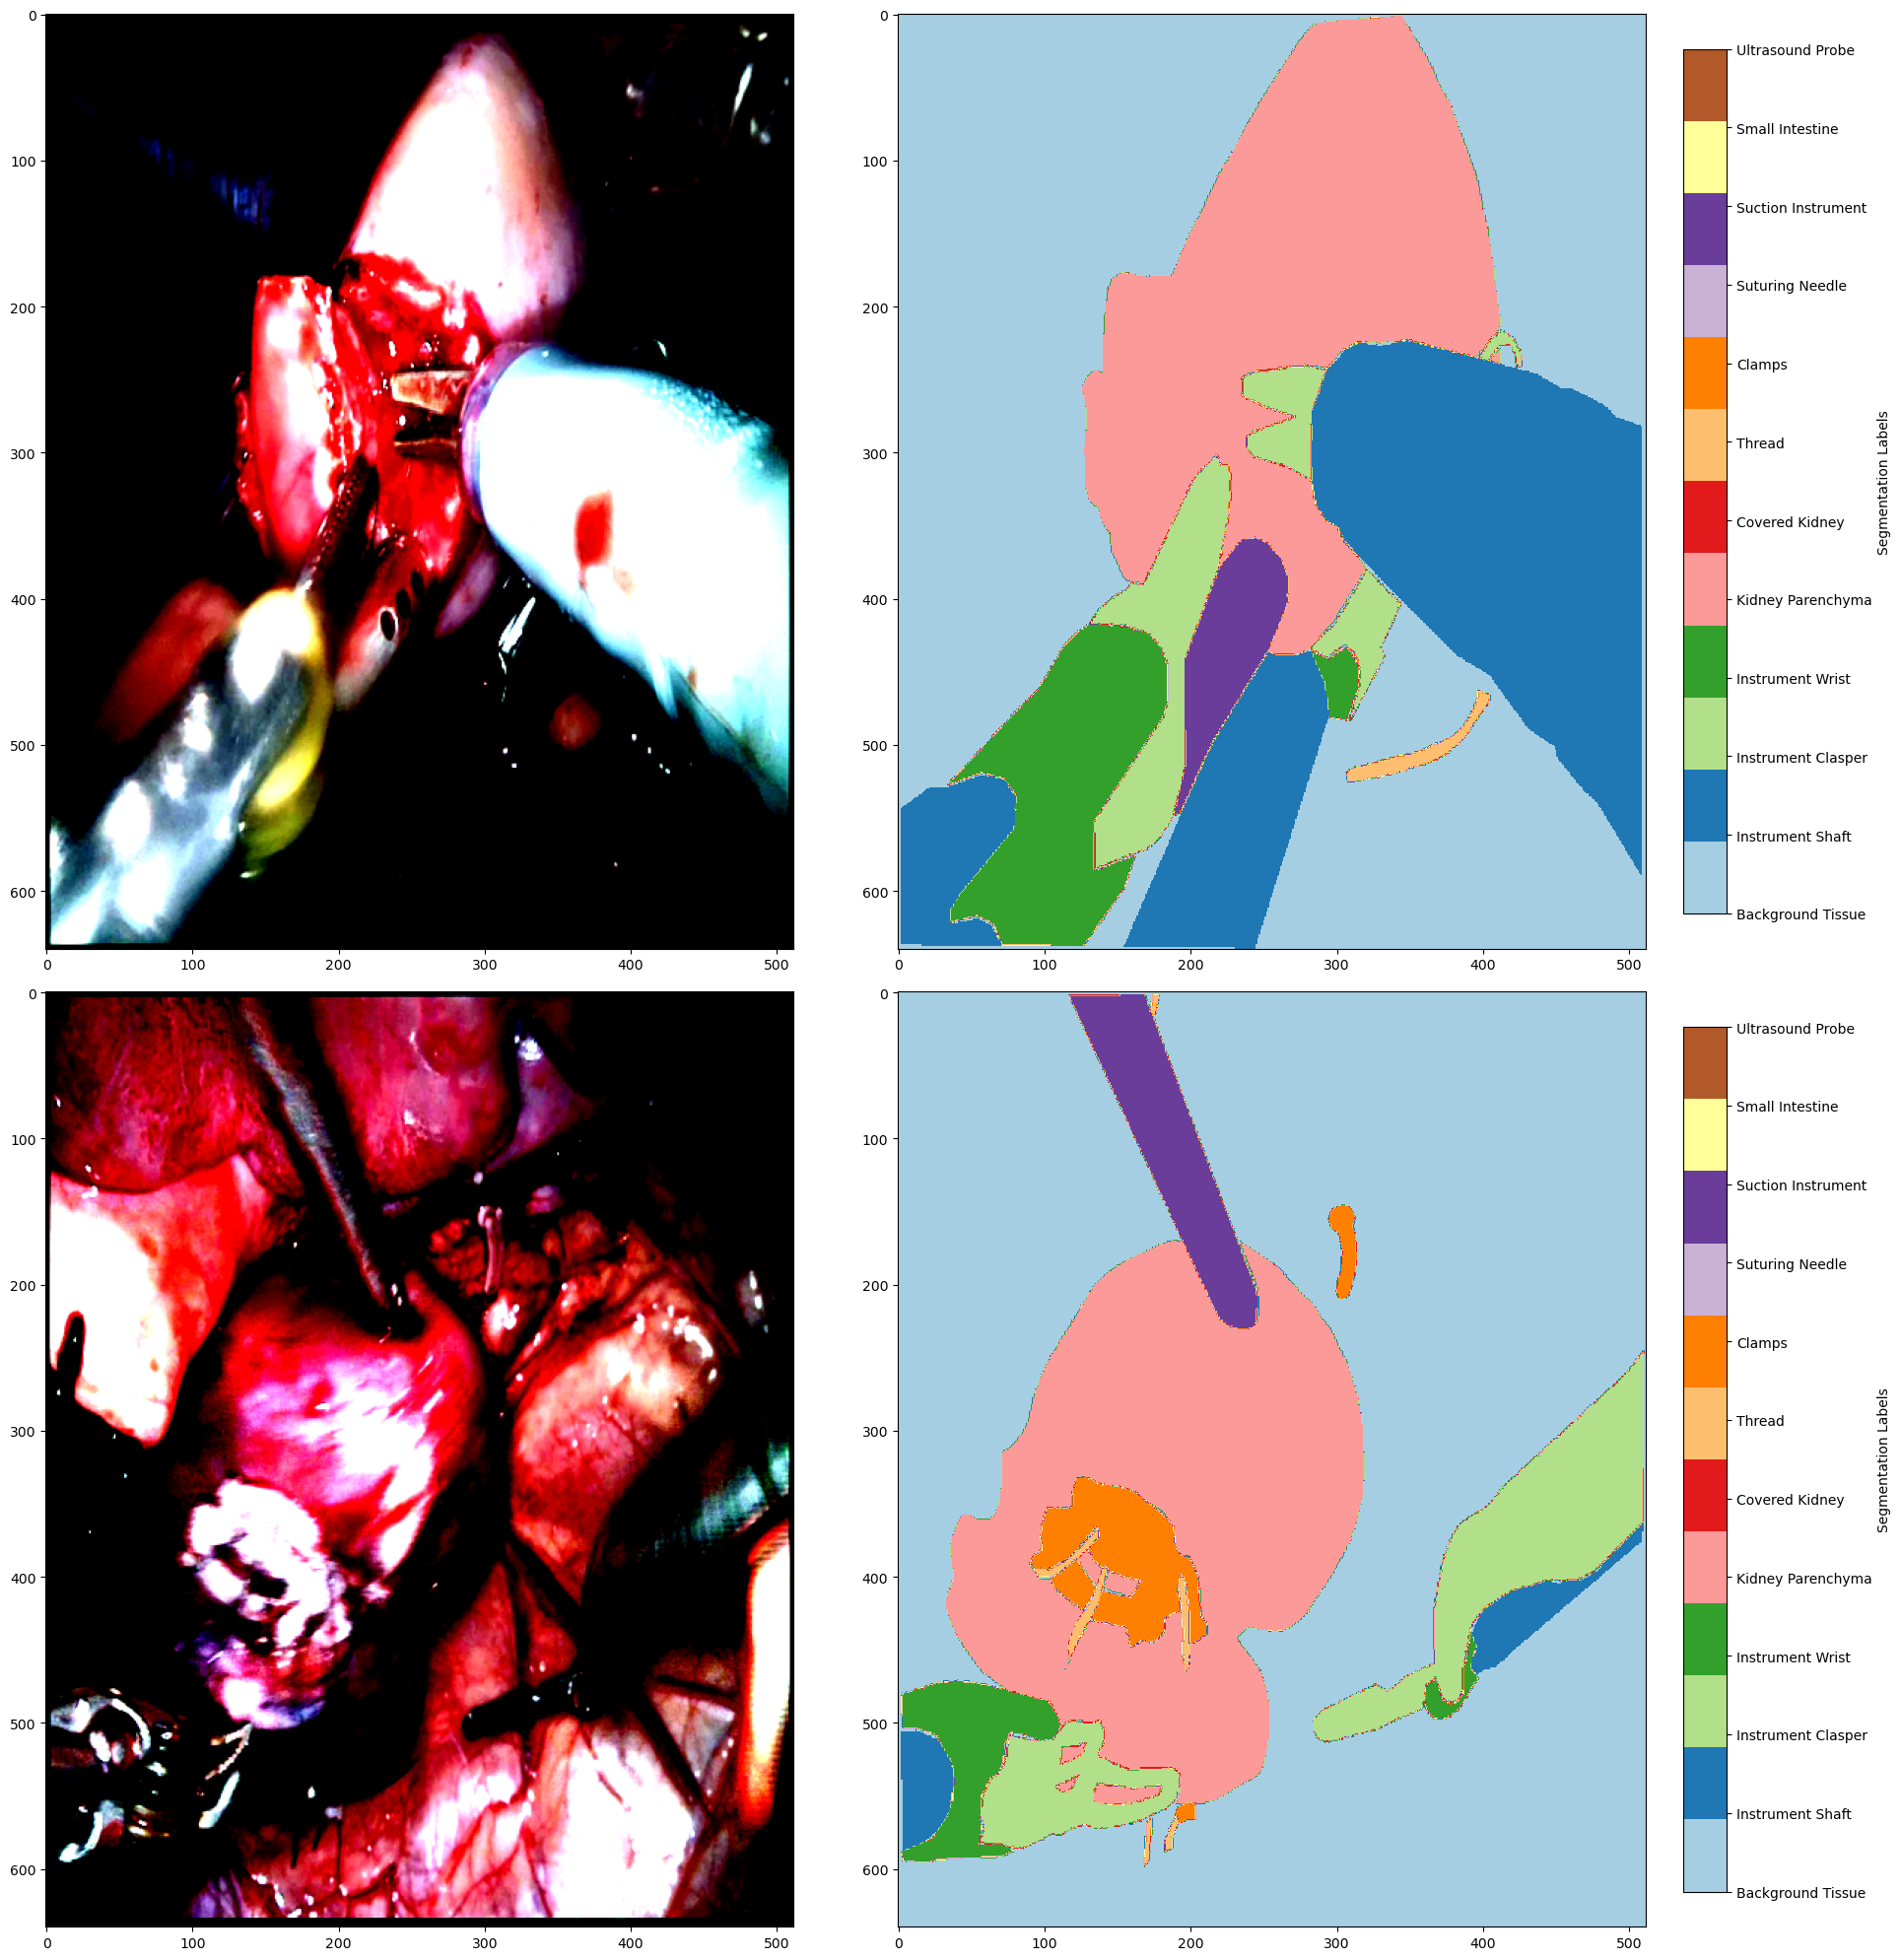

In [ ]:
# get dataloaders and display test images
batch_size = 10
reduce_factor = 2 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
images,labels = next(iter(train_dataloader))

n = 2
cmap = plt.get_cmap('Paired',12)
cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
               "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]


fig, axes = plt.subplots(n, 2, figsize=(20, 20))
for i in range(n):  # Flatten the 2D array of axes
    axes[i,0].imshow(images[i].permute(1, 2, 0))  
    #axes[i,1].imshow(labels[i].permute(1, 2, 0))
    label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
    im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
    # colorbar settings
    cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
    cbar.set_label("Segmentation Labels", fontsize=10)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)

plt.tight_layout()
plt.show()

In [ ]:
# check encoder and BBA
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,1280]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

## Create Model and Hyperparameters


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 40
lr = 1e-4

model = create_ViTModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # learning rate scheduler